In [20]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator

from auto_robot_design.optimization.saver import (
    ProblemSaver, )

from auto_robot_design.description.utils import (
    draw_joint_point, )
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE

### Parametrization

#### 1) mechanism configuration

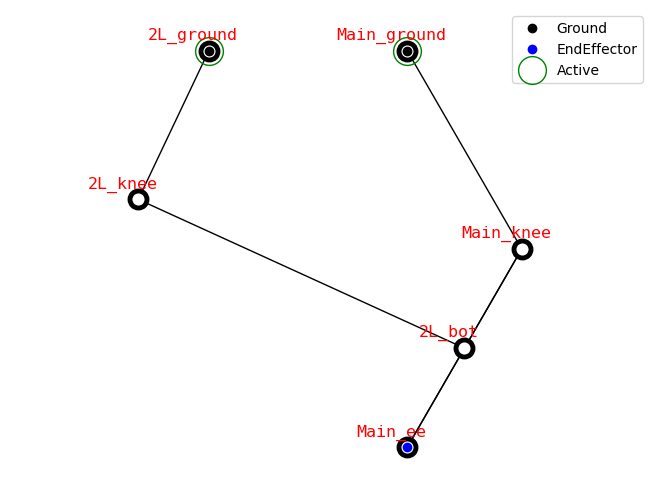

In [21]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set()
graph, constrain_dict = all_graphs[0]

actuator = TMotor_AK70_10()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
draw_joint_point(graph)

#### 2) set optimization task

In [22]:
# trajectories
x_traj, y_traj = get_simple_spline()
traj_6d_step = convert_x_y_to_6d_traj_xz(x_traj, y_traj)
x_traj_, y_traj_ = get_vertical_trajectory(50)
traj_6d_vertical = convert_x_y_to_6d_traj_xz(x_traj_, y_traj_)
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}

# set the rewards and weights for the optimization task
rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1),
                (AccelerationCapability(manipulability_key='Manip_Jacobian',
                 trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass"), 1)
                ]
rewards_step = [(VelocityReward(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error"), 1),
                ]

rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1),
                    (HeavyLiftingReward(manipulability_key='Manip_Jacobian',
                     trajectory_key="traj_6d", error_key="error", mass_key="MASS"), 1)
                    ]

rewards_vertical = []


In [23]:
# activate multiprocessing
N_PROCESS = 12
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# class that enables calculating of criteria along the trajectory for the urdf description of the mechanism
crag_step = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria, traj_6d_step)
# set the rewards and weights for the optimization task
crag_vertical = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria, traj_6d_vertical)

criteria_and_rewards = [(crag_step, rewards_step),(crag_vertical, rewards_vertical)]

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

In [24]:
# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            criteria_and_rewards=criteria_and_rewards,
                                            elementwise_runner=runner, Actuator = actuator)
saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=25, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 1,
        "termination": ("n_gen", 20),
        "verbose": True
    })

# best_id = np.argmin(optimizer.history["F"])
# best_x = optimizer.history["X"][best_id]
# best_reward = optimizer.history["F"][best_id]
# problem.mutate_JP_by_xopt(best_x)
# best_vector.append((problem.graph, j, best_reward))



     1 |       25 |        - |       - |  0.9000 |  2.00000 |  2.00000 | -5.161451E-01 | -1.261387E+00
     2 |       50 |  0.39280 |       2 |  0.6493 |  2.04585 |  1.95415 | -7.581703E-01 | -1.536365E+00
     3 |       75 |  0.03484 |       3 |  0.4219 |  2.04491 |  1.97568 | -1.086316E+00 | -2.247950E+00
     4 |      100 |  0.04991 |       3 |  0.4315 |  2.03369 |  1.99345 | -1.292988E+00 | -2.247950E+00
     5 |      125 | -3.3E-02 |       3 |  0.3796 |  2.01951 |  2.01163 | -1.487543E+00 | -2.247950E+00
     6 |      150 | -2.7E-02 |       3 |  0.3830 |  2.00385 |  2.01883 | -1.564974E+00 | -2.247950E+00
     7 |      175 | -2.4E-02 |       3 |  0.3854 |  1.99271 |  2.03419 | -1.637473E+00 | -2.247950E+00
     8 |      200 | -2.4E-02 |       3 |  0.3853 |  1.97969 |  2.04150 | -1.690308E+00 | -2.247950E+00
     9 |      225 | -1.9E-02 |       3 |  0.3884 |  1.96980 |  2.05306 | -1.831422E+00 | -2.253685E+00
    10 |      250 | -2.8E-02 |       3 |  0.3828 |  1.95939 |  2.06539 | 

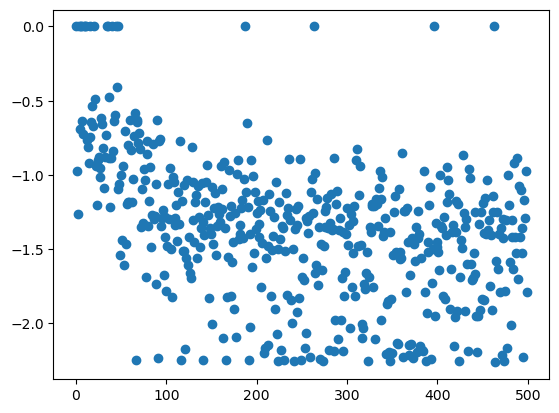

In [25]:
plt.scatter(np.arange(len(optimizer.history["F"])),optimizer.history["F"])

In [26]:
best_id = np.argmin(optimizer.history["F"])
best_reward = optimizer.history["F"][best_id]
best_reward

array([-2.26250383])

In [27]:
from auto_robot_design.optimization.visualizer import (
    prepare_data_to_visualize,
    draw_jps_cost_on_graph,
    prepare_data_to_visualize_separeate_jps,
    draw_jps_distribution,
    draw_costs,
    MARKERS,
)
features, costs, total_cost = prepare_data_to_visualize_separeate_jps(
    optimizer.history, problem
)

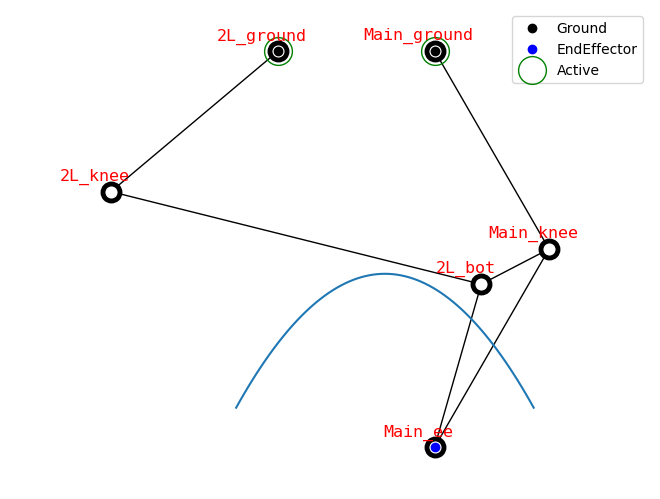

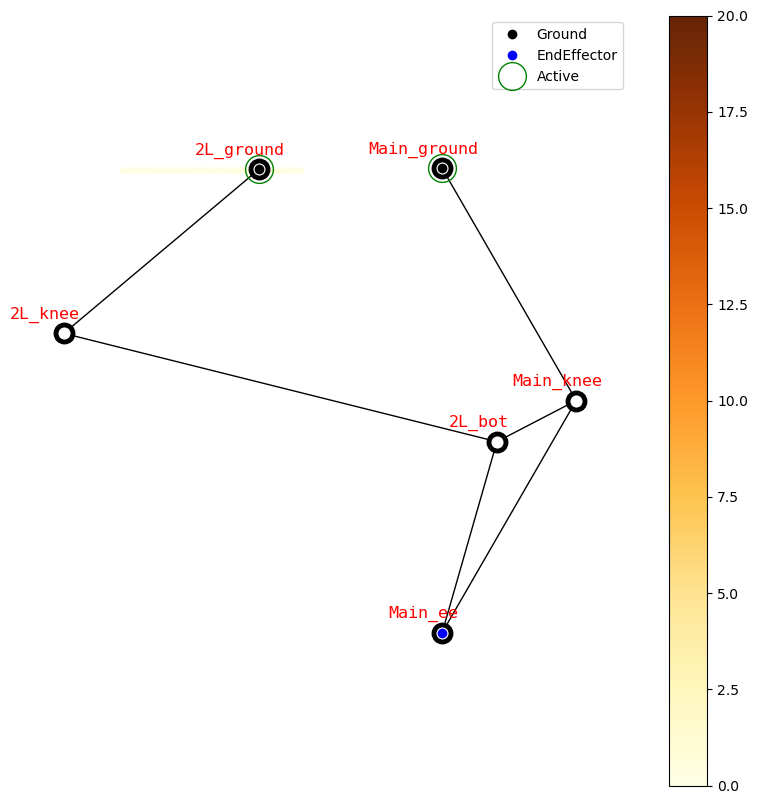

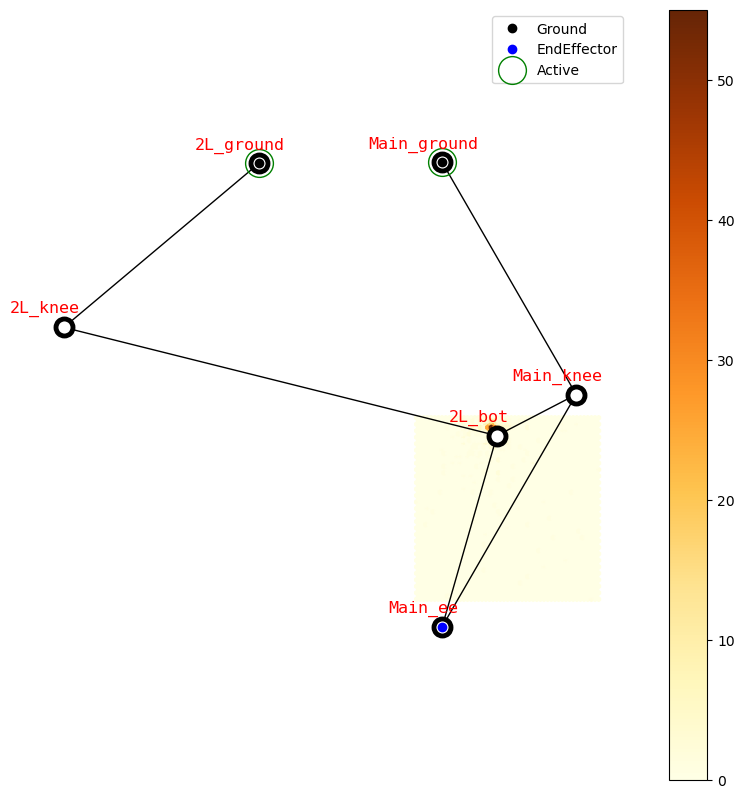

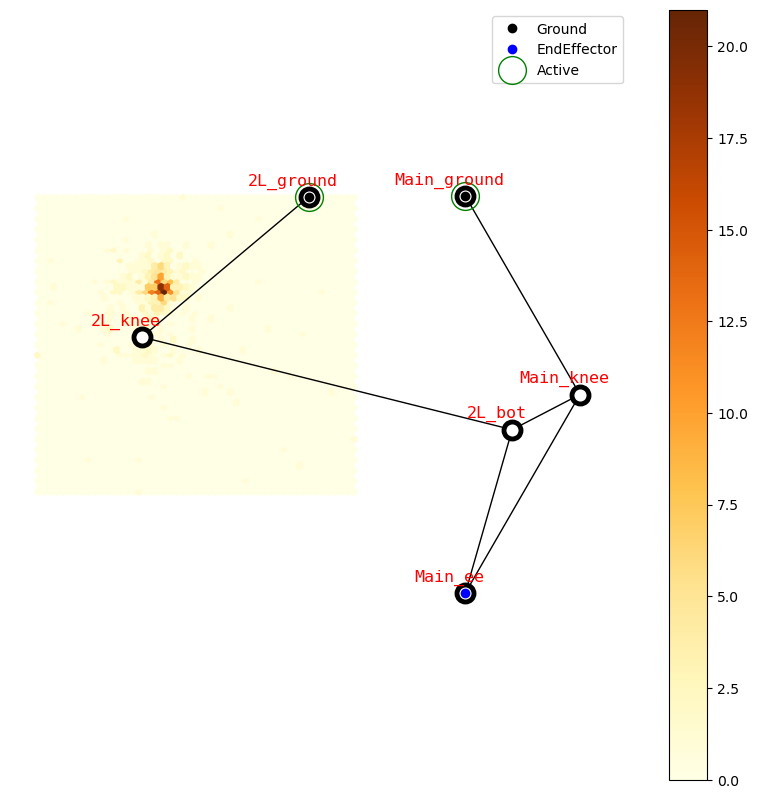

In [28]:
best_x = optimizer.history["X"][best_id]
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)
plt.plot(x_traj,y_traj)
# problem.mutate_JP_by_xopt(problem.initial_xopt)
# draw_joint_point(problem.graph)

for id, feat in enumerate(features):
    plt.figure(figsize=(10, 10))
    marker = MARKERS[id % len(MARKERS)]
    # draw_jps_cost_on_graph(feat, costs[:, 0], problem, marker)
    draw_jps_distribution(feat)
    draw_joint_point(problem.graph)
    plt.colorbar()
    plt.axis("equal")
    plt.show()

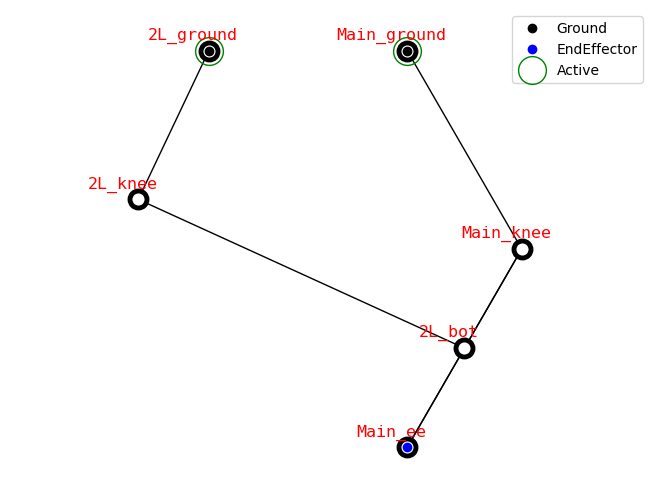

In [29]:
problem.mutate_JP_by_xopt(problem.initial_xopt)
draw_joint_point(problem.graph)

In [30]:
constrain_dict

{'Main_ground': {'optim': False,
  'x_range': (-0.2, 0.2),
  'z_range': (-0.2, 0.2)},
 'Main_knee': {'optim': False, 'x_range': (-0.2, 0.2), 'z_range': (-0.2, 0.2)},
 'Main_ee': {'optim': False, 'x_range': (-0.2, 0.2), 'z_range': (-0.2, 0.2)},
 '2L_ground': {'optim': True, 'x_range': (-0.2, 0.2)},
 '2L_bot': {'optim': True, 'x_range': (-0.2, 0.2), 'z_range': (-0.2, 0.2)},
 '2L_knee': {'optim': True, 'x_range': (-0.4, 0.4), 'z_range': (-0.4, 0.4)}}

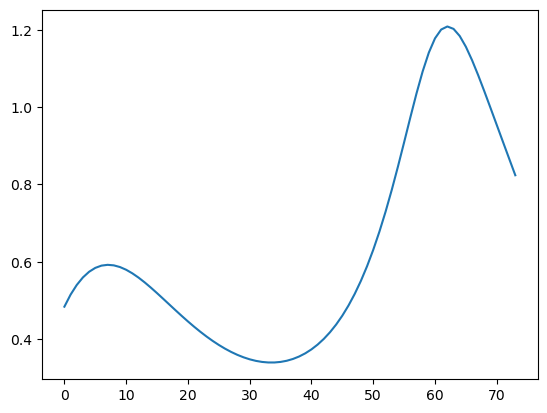

In [31]:
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
crag = criteria_and_rewards[0][0]
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph,builder=builder)
point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot)

reward = criteria_and_rewards[0][1][0][0]
print(reward)
reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])
plt.plot(reward_vector)